
Training Value Iteration...


100%|██████████| 10000/10000 [00:11<00:00, 833.82it/s]



Training Policy Iteration...


100%|██████████| 10000/10000 [00:11<00:00, 892.74it/s]



Training Q-Learning...


100%|██████████| 10000/10000 [00:11<00:00, 888.11it/s]



Training Monte Carlo...


100%|██████████| 10000/10000 [00:12<00:00, 775.69it/s]



Training SARSA...


100%|██████████| 10000/10000 [00:10<00:00, 961.67it/s]


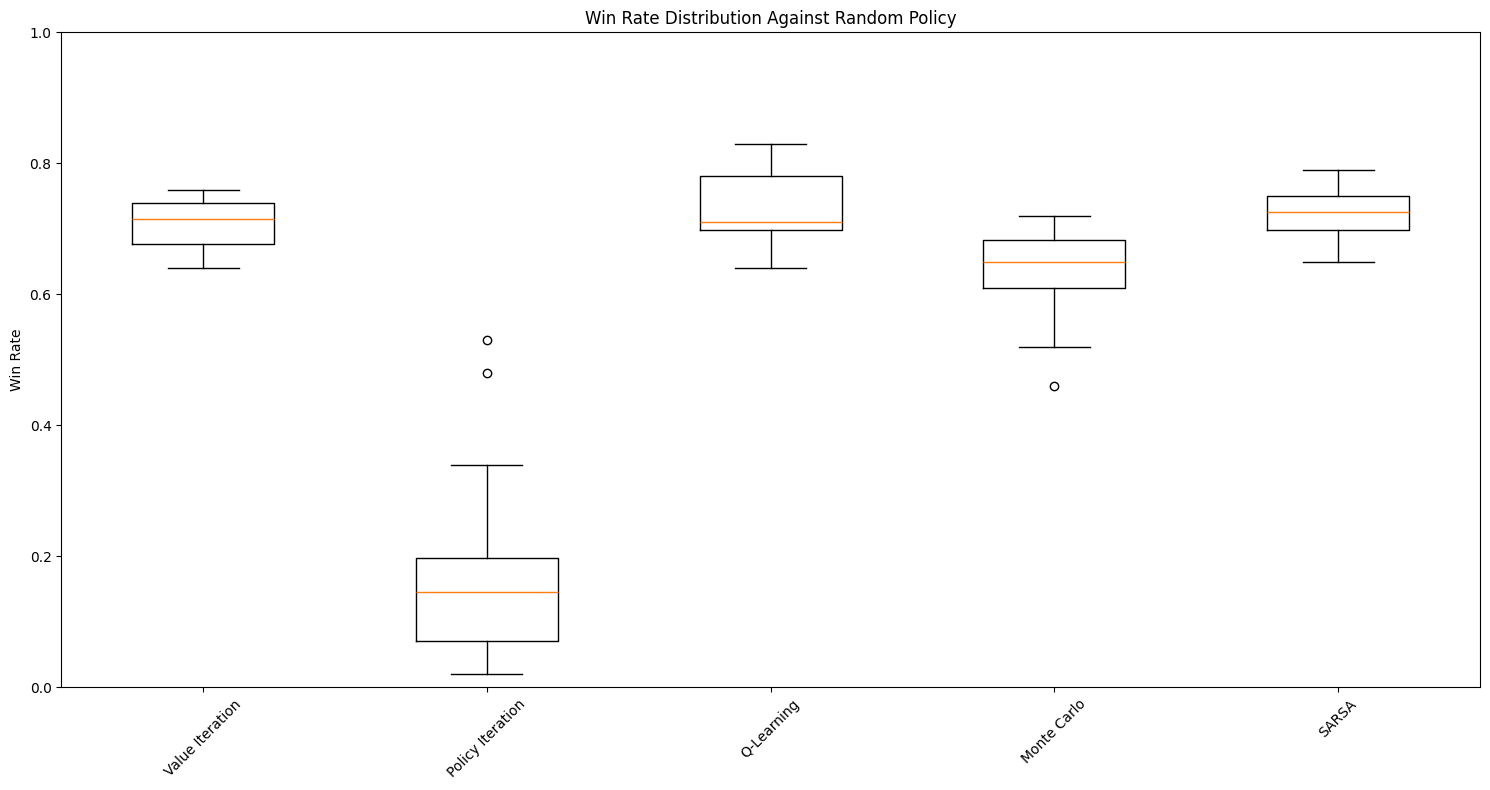


Value Iteration:
Final average win rate: 0.708
Standard deviation: 0.038

Policy Iteration:
Final average win rate: 0.170
Standard deviation: 0.142

Q-Learning:
Final average win rate: 0.728
Standard deviation: 0.054

Monte Carlo:
Final average win rate: 0.632
Standard deviation: 0.067

SARSA:
Final average win rate: 0.726
Standard deviation: 0.036


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from collections import defaultdict

class TicTacToe4x4:
    def __init__(self):
        self.board = np.zeros((4, 4))
        self.current_player = 1  # 1 for X, -1 for O

    def reset(self):
        self.board = np.zeros((4, 4))
        self.current_player = 1
        return self.get_state()

    def get_state(self):
        return str(self.board.tolist())

    def get_valid_moves(self):
        return [(i, j) for i in range(4) for j in range(4) if self.board[i][j] == 0]

    def make_move(self, move):
        i, j = move
        if self.board[i][j] != 0:
            return False
        self.board[i][j] = self.current_player
        return True

    def check_winner(self):
        # Check rows, columns and diagonals
        for i in range(4):
            if abs(sum(self.board[i,:])) == 4:
                return self.board[i,0]
            if abs(sum(self.board[:,i])) == 4:
                return self.board[0,i]

        # Diagonals
        if abs(sum(np.diag(self.board))) == 4:
            return self.board[0,0]
        if abs(sum(np.diag(np.fliplr(self.board)))) == 4:
            return self.board[0,3]

        # Check for draw
        if len(self.get_valid_moves()) == 0:
            return 0

        return None

    def step(self, action):
        if not self.make_move(action):
            return self.get_state(), -10, True

        winner = self.check_winner()
        done = winner is not None

        reward = 0
        if done:
            if winner == 1:
                reward = 1
            elif winner == -1:
                reward = -1

        self.current_player *= -1
        return self.get_state(), reward, done

class PolicyIteration:
    def __init__(self, gamma=0.9):
        self.policy = defaultdict(lambda: None)
        self.values = defaultdict(float)
        self.gamma = gamma
        self.returns = defaultdict(list)

    def get_action(self, state, valid_moves, epsilon=0):
        if random.random() < epsilon or self.policy[state] is None:
            return random.choice(valid_moves)
        return self.policy[state]

    def update(self, state, action, reward, next_state, done):
        state_action = f"{state}_{action}"
        if done:
            self.values[state_action] = reward
        else:
            self.values[state_action] = reward + self.gamma * max(
                [self.values[f"{next_state}_{a}"] for a in [(i,j) for i in range(4) for j in range(4)]]
                + [0]
            )

        # Update policy
        best_value = float('-inf')
        best_action = None
        for a in [(i,j) for i in range(4) for j in range(4)]:
            value = self.values[f"{state}_{a}"]
            if value > best_value:
                best_value = value
                best_action = a
        self.policy[state] = best_action

class QLearning:
    def __init__(self, gamma=0.9, alpha=0.1):
        self.q_values = defaultdict(float)
        self.gamma = gamma
        self.alpha = alpha

    def get_action(self, state, valid_moves, epsilon=0):
        if random.random() < epsilon:
            return random.choice(valid_moves)

        return max(valid_moves, key=lambda a: self.q_values[f"{state}_{a}"])

    def update(self, state, action, reward, next_state, done):
        state_action = f"{state}_{action}"
        if done:
            target = reward
        else:
            next_actions = [(i,j) for i in range(4) for j in range(4)]
            target = reward + self.gamma * max(
                [self.q_values[f"{next_state}_{a}"] for a in next_actions]
            )

        self.q_values[state_action] += self.alpha * (target - self.q_values[state_action])

class MonteCarlo:
    def __init__(self, gamma=0.9):
        self.q_values = defaultdict(float)
        self.returns = defaultdict(list)
        self.gamma = gamma

    def get_action(self, state, valid_moves, epsilon=0):
        if random.random() < epsilon:
            return random.choice(valid_moves)

        return max(valid_moves, key=lambda a: self.q_values[f"{state}_{a}"])

    def update(self, episode):
        G = 0
        for state, action, reward in reversed(episode):
            G = reward + self.gamma * G
            state_action = f"{state}_{action}"
            self.returns[state_action].append(G)
            self.q_values[state_action] = np.mean(self.returns[state_action])

class Sarsa:
    def __init__(self, gamma=0.9, alpha=0.1):
        self.q_values = defaultdict(float)
        self.gamma = gamma
        self.alpha = alpha

    def get_action(self, state, valid_moves, epsilon=0):
        if random.random() < epsilon:
            return random.choice(valid_moves)

        return max(valid_moves, key=lambda a: self.q_values[f"{state}_{a}"])

    def update(self, state, action, reward, next_state, next_action, done):
        state_action = f"{state}_{action}"
        if done:
            target = reward
        else:
            target = reward + self.gamma * self.q_values[f"{next_state}_{next_action}"]

        self.q_values[state_action] += self.alpha * (target - self.q_values[state_action])

def play_game(agent, env, epsilon=0, train=True):
    state = env.reset()
    done = False
    episode = []

    while not done:
        valid_moves = env.get_valid_moves()

        if env.current_player == 1:  # Agent's turn
            action = agent.get_action(state, valid_moves, epsilon)
            if isinstance(agent, Sarsa):
                next_state, reward, done = env.step(action)
                if not done:
                    next_valid_moves = env.get_valid_moves()
                    next_action = agent.get_action(next_state, next_valid_moves, epsilon)
                    if train:
                        agent.update(state, action, reward, next_state, next_action, done)
                else:
                    if train:
                        agent.update(state, action, reward, next_state, None, done)
            else:
                next_state, reward, done = env.step(action)
                if train:
                    if isinstance(agent, MonteCarlo):
                        episode.append((state, action, reward))
                    else:
                        agent.update(state, action, reward, next_state, done)
        else:  # Random opponent
            action = random.choice(valid_moves)
            next_state, reward, done = env.step(action)

        state = next_state

    if train and isinstance(agent, MonteCarlo):
        agent.update(episode)

    return reward

# Training and evaluation
episodes = 10000
evaluation_games = 100
evaluation_intervals = 500

algorithms = {
    'Value Iteration': ValueIteration(),
    'Policy Iteration': PolicyIteration(),
    'Q-Learning': QLearning(),
    'Monte Carlo': MonteCarlo(),
    'SARSA': Sarsa()
}

results = {name: [] for name in algorithms.keys()}

for name, agent in algorithms.items():
    print(f"\nTraining {name}...")
    env = TicTacToe4x4()

    for episode in tqdm(range(episodes)):
        epsilon = max(0.01, 1.0 - episode/episodes)
        play_game(agent, env, epsilon=epsilon, train=True)

        if (episode + 1) % evaluation_intervals == 0:
            wins = 0
            for _ in range(evaluation_games):
                reward = play_game(agent, env, epsilon=0, train=False)
                if reward == 1:
                    wins += 1
            results[name].append(wins/evaluation_games)

# Plotting
plt.figure(figsize=(15, 8))
plt.boxplot([results[name] for name in algorithms.keys()], labels=algorithms.keys())
plt.title('Win Rate Distribution Against Random Policy')
plt.ylabel('Win Rate')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print final statistics
for name in algorithms.keys():
    print(f"\n{name}:")
    print(f"Final average win rate: {np.mean(results[name]):.3f}")
    print(f"Standard deviation: {np.std(results[name]):.3f}")